In [1]:
!pip install --upgrade tensorflow jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 MB 18.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 

In [3]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
# from keras.layers.wrappers import TimeDistributed
from keras.layers import TimeDistributed

In [4]:
from pathlib import Path

def count_png_files(directory):
    return sum(1 for file in Path(directory).rglob('*.png'))

path = '/kaggle/input/cwt-images-eeg-fatigue-data'
num_samples = count_png_files(path)
print("Total .png files:", num_samples)

Total .png files: 12473


In [5]:
import cv2
import numpy as np
from tqdm import tqdm

# image_shape = (224, 224, 3)  # adjust as needed
image_shape = (224, 224, 3)

# Preallocate empty array
X = np.zeros((num_samples, *image_shape), dtype=np.float32)  # or float32 if needed
Y = np.zeros((num_samples,), dtype=np.float32)

index = 0

for sub_id in tqdm(sorted(os.listdir(path + "/Images"))):
    for label in sorted(os.listdir(path + "/Images/" + sub_id)):
        for image in sorted(os.listdir(path + "/Images/" + sub_id + "/" + label)):
            image_path = os.path.join(path, "Images", sub_id, label, image)
            image_array = cv2.imread(image_path)
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
            #image_array = cv2.resize(image_array, (128,128))

            if image_array is None:
                print("skipping")
                continue  # skip corrupted or unreadable images

            # X.append(image_array / 255.0)
            X[index] = image_array / 255.0

            if label.lower() == "fatigue":
                Y[index] = 1
            elif label.lower() == "normal":
                Y[index] = 0

            index += 1

100%|██████████| 12/12 [01:26<00:00,  7.23s/it]


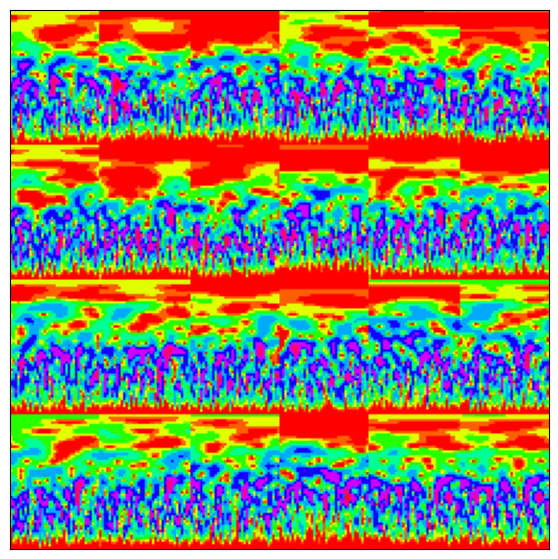

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
# plt.imshow(Normal_npy[0][0])
plt.imshow(X[0])
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [7]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)

len(x_train), len(x_test)

(8731, 3742)

In [8]:
y_test[:100]

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Define input shape
input_shape = (224, 224, 3)

# Load VGG16 base model without the top layers (fully connected layers)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the base model (optional)
base_model.trainable = False  # Set to True if you want to fine-tune

# Build the full model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # You could also use Flatten()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Use 'sigmoid' for multilabel classification

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


I0000 00:00:1753949036.325986     112 service.cc:152] XLA service 0x7af80000eb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753949036.326038     112 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753949036.823792     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/273 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5234 - loss: 0.7567 

I0000 00:00:1753949045.179177     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.5557 - loss: 0.7090 - val_accuracy: 0.6411 - val_loss: 0.6190
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.6586 - loss: 0.6189 - val_accuracy: 0.6689 - val_loss: 0.5901
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - accuracy: 0.6683 - loss: 0.5948 - val_accuracy: 0.7004 - val_loss: 0.5618
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.6956 - loss: 0.5741 - val_accuracy: 0.7023 - val_loss: 0.5573
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.7060 - loss: 0.5575 - val_accuracy: 0.6815 - val_loss: 0.5853
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - accuracy: 0.7174 - loss: 0.5411 - val_accuracy: 0.6994 - val_loss: 0.5619
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.7279 - loss: 0.5407 - val_accuracy: 0.7362 - val_loss: 0.5136
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - accuracy: 0.7377 - loss: 0.520